In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import sys

In [2]:
sys.path.append('/home/local/WIN/msang2/mankun/Notebooks/[01]dimerEnhanceProteinDNA/')
# modules for direct calculation
import analytics as ana
import analyzeEqui as num
# stochastic simulation (Gillespie)
# from Simulations.odeSolver.reversible.singleS import labels
from Simulations.odeSolver.singleS import rxnNetwork as rxnSingleS, labels as labelsSingleS
from Simulations.odeSolver.Nonly import rxnNetwork as rxnNonly, labels as labelsNonly
from Simulations.odeSolver.main import main as numericSolver
# for generating parameters
from GenerateParameters import GenParameters

In [3]:
def plotHeader(
    scale=1.0, fixSize=True, sizeX=5, sizeY=5,
    lgdLoc=[0.55,0.00], lgdFontSize=22, lgdHandleL=0.3, 
    lgdTitle='', lgdTtlFontSize=22,
    labelFontSize=20, tickFontSize=27, 
    tickL=15, tickW=2, spineLineW=2
):
    labelfont = {'fontsize':labelFontSize*scale}
    tickfont = {'fontsize':tickFontSize*scale}
    legend = {'fontsize':lgdFontSize*scale, 'loc':lgdLoc, 'handlelength':lgdHandleL*scale, 
              'title':lgdTitle, 'title_fontsize':lgdTtlFontSize*scale,
             'framealpha':0.0}
    if fixSize:
        fig = plt.figure(figsize=(sizeX*scale,sizeY*scale))
        ax = fig.add_subplot(111)
    else:
        ax = plt.gca()
    plt.tick_params(length=tickL*scale, width=tickW*scale)
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(spineLineW*scale)  # change width
    colors = [
        'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
        'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'
    ]
    linsStyles = ['-', '--']
    return ax, colors, linsStyles, legend, labelfont, tickfont, 0.6022 # C0, nm^-3 -> M

# SI) distribution of residence time

In [5]:
def criticalRate(parm):
    kbPS = parm['kbPS'].to_numpy()
    kbPN = parm['kbPN'].to_numpy()
    kbPP = parm['kbPP'].to_numpy()
    chiN = parm['KPN'].to_numpy()*parm['CN0'].to_numpy()
    chiS = parm['KPS'].to_numpy()*parm['CS0'].to_numpy()
    gamma = parm['gamma'].to_numpy()
    chiDNA = chiN + chiS + gamma*chiS*chiN
    onRate = (kbPS*chiS + kbPN*chiN)
    nu = (onRate*(2*gamma*chiN*chiS + gamma*chiN**2 + 2*(gamma*chiN)**2*chiS))
    return nu/chiDNA**2

def criticalRate_approx(parm):
    kbPS = parm['kbPS'].to_numpy()
    kbPN = parm['kbPN'].to_numpy()
    kbPP = parm['kbPP'].to_numpy()
    chiN = parm['KPN'].to_numpy()*parm['CN0'].to_numpy()
    chiS = parm['KPS'].to_numpy()*parm['CS0'].to_numpy()
    gamma = parm['gamma'].to_numpy()
    onRate = (kbPS*chiS + kbPN*chiN)
    return (onRate*gamma*chiN*2)/(1 + gamma*chiN)/chiS

In [6]:
def monomerDwellPDF(t, parm):
    konS = parm['kaPS'].iloc[0]*parm['CS0'].iloc[0]
    konN = parm['kaPN'].iloc[0]*parm['CN0'].iloc[0]
    Y = parm['gamma'].iloc[0]
    kbS = parm['kbPS'].iloc[0]
    kbN = parm['kbPN'].iloc[0]
    
    Kmatrix = [
        [-kbN - Y*konS, 0,             kbS],
        [0,             -kbS - Y*konN, kbN],
        [Y*konS,        Y*konN,        -kbS - kbN]
    ]
    
    eVals, eVecs = np.linalg.eig(Kmatrix)
    
    x0 = [1, 0, 0]
    coef = np.dot(np.linalg.inv(eVecs.T), x0)
    sPN = coef[0]*np.exp(eVals[0]*t)*np.sum(eVecs[0])
    sPN += coef[1]*np.exp(eVals[1]*t)*np.sum(eVecs[1])
    sPN += coef[2]*np.exp(eVals[2]*t)*np.sum(eVecs[2])
    
    return sPN

In [7]:
GenParms = lambda kbP, nDenseKPP :GenParameters(
    numTargets=2, KPS=lambda KPN: 100*KPN, kaPS=1000, kaPN=200,
    KPN=[200], NP0=[0.1], area3Dto1D=[30], kbPP_fixed=kbP,
    KPP=[0, 1e6, 1e9],
)

In [8]:
parm_num = GenParms(0.04, 0)

print(criticalRate(GenParms(1, 0)))

equi_num = numericSolver(parm_df=parm_num, labels=labelsSingleS, model=rxnSingleS)

[0.10003831 0.10003831 0.10003831]
2025-01-03 09:12:58.394703
Number of cores used:  3/36
Finished parallel processing.


In [340]:
from pathlib import Path

pdir = '../Simulations/Gillespie/DNAtarg:criticDimer.bak.kbP004//'
Path(pdir).mkdir(parents=True, exist_ok=True)
parm_num.to_csv(pdir+'/parameters.csv')
equi_num.to_csv(pdir+'/equilibrium.csv')

In [9]:
def readGillespieSurvP(filename):
    with open(filename) as f:
        reading = False
        times = []
        survP = []
        numDiss = 'Not Read'
        for line in f:
            if line.strip() == '# START SURVIVAL PROB':
                reading = True
            elif line.strip() == '# END SURVIVAL PROB':
                reading = False
            elif line.strip() == '# Mean Residence Time':
                meanResT = float(f.readline().strip())
            elif line.strip().startswith('Number of dissociation events:'):
                numDiss = int(line.split(':')[1])
            else:
                if reading:
                    linelist = line.split()
                    times.append(float(linelist[0]))
                    survP.append(float(linelist[1]))
    return np.array(times), np.array(survP), meanResT, numDiss

def resample_time_sequence(sequence, dt):
    """
    Sample from the input sequence to ensure time steps are at least `dt` apart.

    Parameters:
        sequence (list): A list of increasing numbers.
        dt (float): Minimum time step between sampled values.

    Returns:
        tuple: A tuple containing:
            - list: A new sequence with time steps at least `dt` apart.
            - list: Indices of the sampled values in the original sequence.
    """
    # Initialize the sampled sequence and indices with the first element
    sampled = [sequence[0]]
    indices = [0]

    # Iterate through the input sequence and add elements that satisfy the condition
    for idx, value in enumerate(sequence):
        if value - sampled[-1] >= dt:
            sampled.append(value)
            indices.append(idx)

    return np.array(sampled), np.array(indices)

def getPDF(fileName, timeStep=0.01):
    times, survP, meanResT, numDiss  = readGillespieSurvP(fileName)
    timeX_origin, timeIdx = resample_time_sequence(times, dt=timeStep)
    timeX = (timeX_origin[1:]+timeX_origin[:-1])/2
    dTimeX = np.diff(timeX_origin)
    probY = -np.diff(survP[timeIdx])
    print(meanResT)
    return timeX, probY/dTimeX

101.81
0.9987960973364636
109.6
0.9996181600477686
111.64
0.9999207765804083


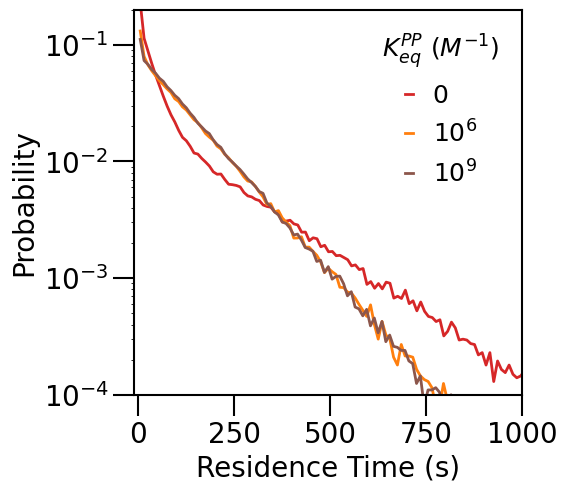

In [17]:
ax, colors, lineStyles, legend, labelfont, tickfont, C0 = plotHeader(
    scale=1.0, fixSize=True, sizeX=5, sizeY=5,
    lgdLoc='best', lgdFontSize=18, lgdHandleL=0.3, 
    lgdTitle='$K_{eq}^{PP}\ (M^{-1})$', lgdTtlFontSize=18,
    labelFontSize=20, tickFontSize=20, 
    tickL=15, tickW=1.5, spineLineW=1.5
)

KPPlog10 = ['0', '$10^6$', '$10^9$']
fileIndex = [0, 1, 2]
lineColors = ['tab:red', 'tab:orange', 'tab:brown']
lineStyles = ['-', '--', ':']
tSampleStep = 10

for i in range(3):
    fileName = f'../Simulations/Gillespie/DNAtarg:criticDimer.bak.kbP005/OUTPUTS_singleS/out_{fileIndex[i]}_r0'
    timeX, probY  = getPDF(fileName, timeStep=tSampleStep)
    plt.plot(
        timeX, probY*tSampleStep, lw=2, color=lineColors[i], 
        ls=lineStyles[0], label=KPPlog10[fileIndex[i]],
    )
    print(np.sum(probY*tSampleStep))

# timePoints = np.linspace(0,2000)
# plt.plot(timePoints[1:], -np.diff(monomerDwellPDF(timePoints, parm_num)))
    
plt.legend(**legend)
plt.xlim([-10,1000])
plt.ylim([1e-4, 2e-1])
plt.semilogy()

plt.xlabel('Residence Time (s)', **labelfont)
plt.ylabel('Probability', **labelfont)
plt.xticks(**tickfont)
plt.yticks(**tickfont)
plt.locator_params(axis='x', nbins=5)

plt.show()

# d) residence time v.s. KPP & C0, dimer, model B

In [53]:
def criticalRate(parm):
    kbPS = parm['kbPS'].to_numpy()
    kbPN = parm['kbPN'].to_numpy()
    kbPP = parm['kbPP'].to_numpy()
    chiN = parm['KPN'].to_numpy()*parm['CN0'].to_numpy()
    chiS = parm['KPS'].to_numpy()*parm['CS0'].to_numpy()
    gamma = parm['gamma'].to_numpy()
    chiDNA = chiN + chiS + gamma*chiS*chiN
    onRate = (kbPS*chiS + kbPN*chiN)
    nu = (onRate*(2*gamma*chiN*chiS + gamma*chiN**2 + 2*(gamma*chiN)**2*chiS))
    return nu/chiDNA**2

def criticalRate_approx(parm):
    kbPS = parm['kbPS'].to_numpy()
    kbPN = parm['kbPN'].to_numpy()
    kbPP = parm['kbPP'].to_numpy()
    chiN = parm['KPN'].to_numpy()*parm['CN0'].to_numpy()
    chiS = parm['KPS'].to_numpy()*parm['CS0'].to_numpy()
    gamma = parm['gamma'].to_numpy()
    onRate = (kbPS*chiS + kbPN*chiN)
    return (onRate*gamma*chiN*2)/(1 + gamma*chiN)/chiS

In [71]:
GenParms = lambda kbP, nDenseKPP :GenParameters(
    numTargets=2, KPS=lambda KPN: 100*KPN, kaPS=1000, kaPN=200,
    KPN=[200], NP0=[0.1], area3Dto1D=[31], # area3Dto1D was 35 in figure plots, I changed this for a k^* closer to 0.01
    KPP=np.logspace(1,9,8+7*nDenseKPP), kbPP_fixed=kbP   
)

parm_num = pd.concat([GenParms(1e-2, 0), GenParms(1e-1, 0), GenParms(1e-0, 0)], axis=0)
parm_ana = pd.concat([GenParms(1e-2, 10), GenParms(1e-1, 10), GenParms(1e-0, 10)], axis=0)

In [72]:
np.unique(criticalRate(parm_num)), np.unique(criticalRate_approx(parm_num))

(array([0.09947657]), array([0.10070099]))

In [80]:
parm_num['gamma'].unique(), parm_num['CP0'].unique()/0.6022

(array([32.25806452]), array([7.90751372e-06]))

In [74]:
resTs = np.zeros(parm_ana.shape[0])
for iloc in range(parm_ana.shape[0]):
    parm = parm_ana.iloc[iloc]
    resTs[iloc] = ana.ana_resTime_balance(parm, numClusterS=1)

In [75]:
equi_num_rev = numericSolver(parm_df=parm_num, labels=labelsSingleS, model=rxnSingleS)

2024-12-31 19:03:02.157761
Number of cores used:  24/36
Finished parallel processing.


In [76]:
resT_num_rev = np.zeros(parm_num.shape[0])
for iloc in range(parm_num.shape[0]):
    resT_num_rev[iloc] = num.calc_resT_modelB(parm_num.iloc[iloc], equi_num_rev.iloc[iloc])

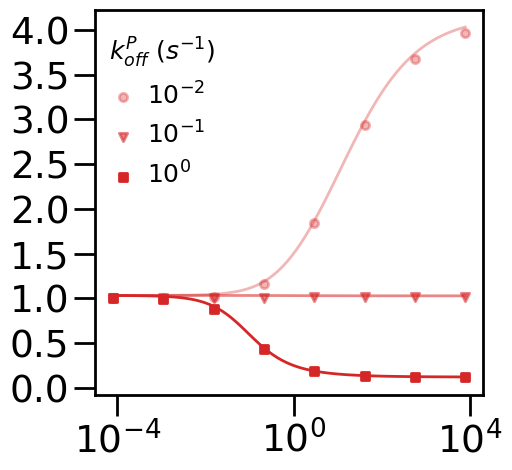

In [79]:
# >>>>>>>>>>>>>>>>>>>>>>>> Initialize Plotting >>>>>>>>>>>>>>>>>>>>>>>>
ax, colors, lineStyles, legend, labelfont, tickfont, C0 = plotHeader(
    scale=1.0, fixSize=True, sizeX=5, sizeY=5,
    lgdLoc=[0.01,0.51], lgdFontSize=18, lgdHandleL=0.3, 
    lgdTitle='$k_{off}^P\ (s^{-1})$', lgdTtlFontSize=18,
    labelFontSize=20, tickFontSize=27, 
    tickL=15, tickW=2, spineLineW=2
)
alphas = [3/9, 5/9, 1]
markers = ['o','v','s']
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
kbList = np.unique(parm_ana['kbPP'])
for i, kbP in enumerate(kbList):
    selected = parm_ana['kbPP']==kbP
    ax.plot(
        (parm_ana['KPP']*parm_ana['CP0'])[selected],
#         (resTs*parm_ana['kbPS'])[selected],
        (resTs/98.981)[selected],
        lw=2, color='tab:red', alpha=alphas[i],
    )
    selected_num = parm_num['kbPP']==kbP
    ax.scatter(
        (parm_num['KPP']*parm_num['CP0'])[selected_num],
#         (resT_num_rev*parm_num['kbPS'])[selected_num],
        (resT_num_rev/98.981)[selected_num],
        lw=2, zorder=5, marker=markers[i], 
        label='$10^{%.0f}$'%np.log10(kbP),
        color='tab:red', alpha=alphas[i], 
    )
ax.semilogx()
# ax.set_aspect(aspect=1, adjustable='box')
plt.legend(**legend)
plt.xticks([1e-4,1e0,1e4],['$10^{-4}$', '$10^{0}$', '$10^{4}$'],**tickfont)
plt.yticks(**tickfont)
# plt.savefig('resT_vs_chiN_gamma_DIMER.png', transparent=True)
plt.show()

# c) residence time v.s. chiPN & gamma, dimer, model B

In [246]:
GenParm = lambda numTarg, nDenseKPN, KPP: GenParameters(
    numTargets=numTarg, KPN=np.logspace(1, 3, 5+2*nDenseKPN)*2.0, 
    KPS=lambda KPN: 1e3*KPN, 
    NP0=[0.1], KPP=[KPP], area3Dto1D=[1, 100], kbPP_fixed=1e-3,
)
# For analytics, KPP does not affect "irr" mor "m", so set it to the value for reversible
KPP = 1e9
parm_ana_B = GenParm(2, 40, KPP)
parm_ana_A = GenParm(0, 40, KPP)
# For numerics, KPP maters
parm_num_B = GenParm(2, 0, KPP)
parm_num_B_m = GenParm(2, 0, 0)
parm_num_B_irr = GenParm(2, 0, np.inf)
parm_num_A = GenParm(0, 0, KPP)
parm_num_A_m = GenParm(0, 0, 0)
parm_num_A_irr = GenParm(0, 0, np.inf)

In [249]:
# calculate the residence time considering PSN
def calc_tauB_m(parms):
    gam = parms['gamma']
    chiN = parms['KPN']*parms['CN0']
    chiS = parms['KPS']*parms['CS0']
    kaStokaN = parms['kaPS']/parms['kaPN']
    CS0toCN0 = parms['CS0']/parms['CN0']
    tauN = 1/parms['kbPN']
    return (chiN+chiS*(1+gam*chiN))/chiN/(1+kaStokaN*CS0toCN0)*tauN

# calculate the residence time considering PSNPN
def calc_tauB_irr(parm_file):
    gam = parm_file['gamma']
    chiN = parm_file['KPN']*parm_file['CN0']
    chiS = parm_file['KPS']*parm_file['CS0']
    kaStokaN = parm_file['kaPS']/parm_file['kaPN']
    CS0toCN0 = parm_file['CS0']/parm_file['CN0']
    tauN = 1/parm_file['kbPN']
    return (2*chiN+gam*chiN**2+2*chiS*(1+gam*chiN)**2)/2/chiN/(1+kaStokaN*CS0toCN0) * tauN

# calculate the residence time considering PNPN
def calc_tauA_irr(parm_file):
    gam = parm_file['gamma']
    chiN = parm_file['KPN']*parm_file['CN0']
    return (1 + gam*chiN/2) / parm_file['kbPN']

parmSize = parm_ana_B.shape[0]
# ratio when KPP -> infty
resT_irr_B2A = calc_tauB_irr(parm_ana_B)/ calc_tauA_irr(parm_ana_A)
# ratio when KPP=0, tauA_m = 1/kbPN
resT_m_B2A = calc_tauB_m(parm_ana_B) * parm_ana_A['kbPN']
# ratio when KPP is finite
resT_rev_B2A = np.zeros(parmSize)
for iloc in range(parmSize):
    resT_rev_B2A[iloc] = ana.ana_resTime_balance(parm_ana_B.iloc[iloc], numClusterS=1)\
    / ana.ana_resTime_balance(parm_ana_A.iloc[iloc], numClusterS=0)

In [250]:
equi_B_irr = numericSolver(parm_df=parm_num_B_irr, labels=labelsSingleS, model=rxnSingleS)
equi_B_rev = numericSolver(parm_df=parm_num_B, labels=labelsSingleS, model=rxnSingleS)
equi_B_m = numericSolver(parm_df=parm_num_B_m, labels=labelsSingleS, model=rxnSingleS)
equi_A_irr = numericSolver(parm_df=parm_num_A_irr, labels=labelsNonly, model=rxnNonly)
equi_A_rev = numericSolver(parm_df=parm_num_A, labels=labelsNonly, model=rxnNonly)
equi_A_m = numericSolver(parm_df=parm_num_A_m, labels=labelsNonly, model=rxnNonly)

2025-01-14 22:00:13.566190
Number of cores used:  10/36
Finished parallel processing.
2025-01-14 22:00:14.061710
Number of cores used:  10/36
Finished parallel processing.
2025-01-14 22:00:14.714712
Number of cores used:  10/36
Finished parallel processing.
2025-01-14 22:00:15.153410
Number of cores used:  10/36
Finished parallel processing.
2025-01-14 22:00:15.341234
Number of cores used:  10/36
Finished parallel processing.
2025-01-14 22:00:15.586696
Number of cores used:  10/36
Finished parallel processing.


In [251]:
numSize = parm_num_B.shape[0]
resT_num_irr_B2A = np.zeros(numSize)
resT_num_rev_B2A = np.zeros(numSize)
resT_num_m_B2A = np.zeros(numSize)
for iloc in range(numSize):
    resT_num_irr_B2A[iloc] = num.calc_resT_modelB(parm_num_B_irr.iloc[iloc], equi_B_irr.iloc[iloc])\
    / num.calc_resT_modelA(parm_num_A_irr.iloc[iloc], equi_A_irr.iloc[iloc])
    resT_num_rev_B2A[iloc] = num.calc_resT_modelB(parm_num_B.iloc[iloc], equi_B_rev.iloc[iloc])\
    / num.calc_resT_modelA(parm_num_A.iloc[iloc], equi_A_rev.iloc[iloc])
    resT_num_m_B2A[iloc] = num.calc_resT_modelB(parm_num_B_m.iloc[iloc], equi_B_m.iloc[iloc])\
    / num.calc_resT_modelA(parm_num_A_m.iloc[iloc], equi_A_m.iloc[iloc])

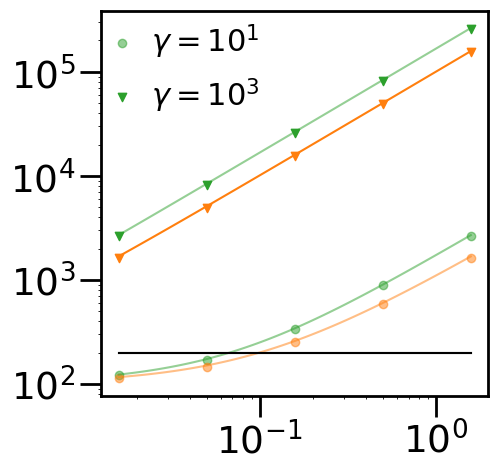

In [252]:
# >>>>>>>>>>>>>>>>>>>>>>>> Initialize Plotting >>>>>>>>>>>>>>>>>>>>>>>>
ax, colors, lineStyles, legend, labelfont, tickfont, C0 = plotHeader(
    scale=1.0, fixSize=True, sizeX=5, sizeY=5,
    lgdLoc=[0.01,0.7], lgdFontSize=22, lgdHandleL=0.3, 
    lgdTitle='', lgdTtlFontSize=22,
    labelFontSize=20, tickFontSize=27, 
    tickL=15, tickW=2, spineLineW=2
)
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
color_gamma = 'tab:green'
alphas = [0.5, 1]
markers = ['o','v']
gamList = np.unique(parm_ana_B['gamma'])
for i, gam in enumerate(gamList):
    ax.plot(
        (parm_ana_B['KPN']*parm_ana_B['CN0'])[selected],
        (1/parm_ana_B['kbPS']*parm_ana_B['kbPN'])[selected],
        color='black', ls='-', alpha=alphas[i], 
    )
    # analytics
    selected = parm_ana_B['gamma']==gam
    ax.plot(
        (parm_ana_B['KPN']*parm_ana_B['CN0'])[selected],
        (resT_irr_B2A)[selected],
        color=color_gamma, ls='-', alpha=0.5, 
    )
    # analytics, monomer limit
    ax.plot(
        (parm_ana_B['KPN']*parm_ana_B['CN0'])[selected],
        (resT_m_B2A)[selected],
        color='tab:orange', ls='-', alpha=alphas[i], 
    )
    # numerics
    selected_num = (parm_num_B['gamma']==gam)
    ax.scatter(
        (parm_num_B['KPN']*parm_num_B['CN0'])[selected_num],
        (resT_num_irr_B2A)[selected_num],
        color=color_gamma, alpha=alphas[i], marker=markers[i],
        label='$\\gamma=10^{%.0f}$'%np.log10(gam),
    )
    # numerics, monomer limit
    ax.scatter(
        (parm_num_B['KPN']*parm_num_B['CN0'])[selected_num],
        (resT_num_m_B2A)[selected_num],
        color='tab:orange', alpha=alphas[i], marker=markers[i],
    )
# ax.semilogx()
ax.loglog()
# ax.set_ylim([1e1,5e5])
plt.legend(**legend)
plt.xticks(**tickfont)
plt.yticks(**tickfont)
plt.savefig('resT_vs_chiN_gamma_DIMER.png', transparent=True)

# a) protein bound ratio (irr, rev, m)

In [18]:
GenParms = lambda KPNList, KPP: GenParameters(
    numTargets=2, KPN=KPNList, KPS=lambda KPN: 2e4, 
    NP0=[0.03], KPP=[KPP], area3Dto1D=[10, 1000],
)
KPP_rev = 1e6

In [19]:
parm_ana = GenParms(np.logspace(1, 3, 5+2*40)*2.0, KPP_rev)

parm_num_irr = GenParms(np.logspace(1, 3, 5+2*0)*2.0, np.inf)
parm_num_rev = GenParms(np.logspace(1, 3, 5+2*0)*2.0, KPP_rev)
parm_num_m = GenParms(np.logspace(1, 3, 5+2*0)*2.0, 0)

In [20]:
np.unique(parm_ana['CP0'])/0.6022, np.unique(parm_ana['KPS'])*0.6022

(array([2.37225412e-06]), array([20000.]))

In [59]:
def pBound_irr(parms):
    gam = parms['gamma']
    chiN = parms['KPN']*parms['CN0']
    chiS = parms['KPS']*parms['CS0']
    proBound = 2*chiN + gam*chiN**2 + 2*chiS*(1+gam*chiN)**2
    return proBound / (1 + proBound)

def pBound_m(parms):
    gam = parms['gamma']
    chiN = parms['KPN']*parms['CN0']
    chiS = parms['KPS']*parms['CS0']
    proBound = chiN + chiS*(1+gam*chiN)
    return proBound / (1 + proBound)

pBound_irr = pBound_irr(parm_ana)
pBound_m = pBound_m(parm_ana)
pBound_rev = np.zeros(parm_ana.shape[0])
for iloc in range(parm_ana.shape[0]):
    pBound_rev[iloc] = ana.ana_bound_ratio(parm_ana.iloc[iloc], numClusterS=1)

In [60]:
equi_irr = numericSolver(parm_df=parm_num_irr, labels=labelsSingleS, model=rxnSingleS)
equi_m = numericSolver(parm_df=parm_num_m, labels=labelsSingleS, model=rxnSingleS)
equi_rev = numericSolver(parm_df=parm_num_rev, labels=labelsSingleS, model=rxnSingleS)

pBound_num_m = np.zeros(parm_num_m.shape[0])
pBound_num_irr = np.zeros(parm_num_m.shape[0])
pBound_num_rev = np.zeros(parm_num_m.shape[0])
for iloc in range(parm_num_m.shape[0]):
    pBound_num_m[iloc] = num.calc_BoundRatio_modelB(parm_num_m.iloc[iloc], equi_m.iloc[iloc])
    pBound_num_irr[iloc] = num.calc_BoundRatio_modelB(parm_num_irr.iloc[iloc], equi_irr.iloc[iloc])
    pBound_num_rev[iloc] = num.calc_BoundRatio_modelB(parm_num_rev.iloc[iloc], equi_rev.iloc[iloc])

2024-10-30 13:54:23.681228
Number of cores used:  10/36
Finished parallel processing.
2024-10-30 13:54:24.181745
Number of cores used:  10/36
Finished parallel processing.
2024-10-30 13:54:24.620458
Number of cores used:  10/36
Finished parallel processing.


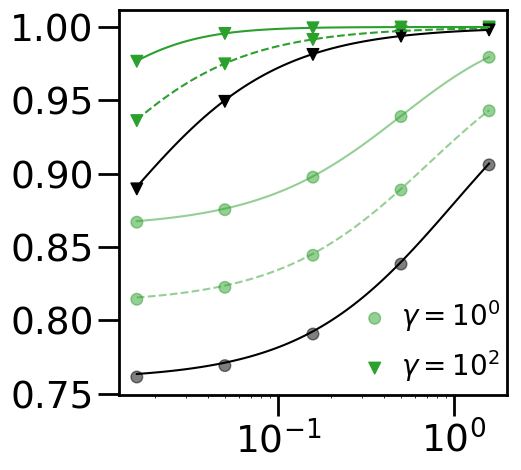

In [65]:
# >>>>>>>>>>>>>>>>>>>>>>>> Initialize Plotting >>>>>>>>>>>>>>>>>>>>>>>>
ax, _, lineStyles, legend, labelfont, tickfont, C0 = plotHeader(
    scale=1.0, fixSize=True, sizeX=5, sizeY=5,
    lgdLoc=[0.62,0.00], lgdFontSize=20, lgdHandleL=0.3, 
    lgdTitle='', lgdTtlFontSize=20,
    labelFontSize=20, tickFontSize=27, 
    tickL=15, tickW=2, spineLineW=2
)
color_gamma = 'tab:green'
alphas = [0.5, 1]
markers = ['o','v']
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
gamList = np.unique(parm_ana['gamma'])
for j, gam in enumerate(gamList):
    selected = ((parm_ana['gamma']==gam))
    # analytics
    ax.plot(
        (parm_ana['KPN']*parm_ana['CN0'])[selected],
        pBound_irr[selected], ls='-',
        color = color_gamma, alpha=alphas[j],
    )
    ax.plot(
        (parm_ana['KPN']*parm_ana['CN0'])[selected],
        pBound_rev[selected], ls='--',
        color = color_gamma, alpha=alphas[j],
    )
    ax.plot(
        (parm_ana['KPN']*parm_ana['CN0'])[selected],
        pBound_m[selected],
        color='black',
    )
    # numerics
    selected_num = ((parm_num_irr['gamma']==gam))
    ax.scatter(
        (parm_num_irr['KPN']*parm_num_irr['CN0'])[selected_num],
        pBound_num_irr[selected_num], s=70,
        ls='', marker=markers[j],
        color=color_gamma, alpha=alphas[j],
        label='$\\gamma=10^{%.0f}$'%np.log10(gam),
    )
    ax.scatter(
        (parm_num_irr['KPN']*parm_num_irr['CN0'])[selected_num],
        pBound_num_rev[selected_num], s=70,
        ls='', marker=markers[j],
        color=color_gamma, alpha=alphas[j],
    )
    ax.scatter(
        (parm_num_m['KPN']*parm_num_m['CN0'])[selected_num],
        pBound_num_m[selected_num],  s=70,
        marker=markers[j], alpha=alphas[j],
        ls='', color='black',
    )
    
ax.semilogx()
# ax.set_aspect(aspect=1, adjustable='box')
plt.legend(**legend)
plt.xticks(**tickfont)
plt.yticks([0.75, 0.8, 0.85, 0.9, 0.95, 1], **tickfont)
# plt.grid(axis='x')
plt.savefig('pBound_vs_chiN_gamma.png', transparent=True)
# plt.show()

In [62]:
np.unique(parm_ana['KPP']*parm_ana['CP0'])

array([2.37225412])

# b) Target occupancy v.s.  KPP & gamma?

In [4]:
def findCriticalXPS(parm):
    '''chiS -> (-chiN + chiN G)/(1 + chiN G)^2'''
    chiN = parm['KPN'].to_numpy()*parm['CN0'].to_numpy()
    gamma = parm['gamma'].to_numpy()
    return chiN*(gamma-1)/(1+gamma*chiN)**2

def findCriticalKPS(parm):
    '''chiS -> (-chiN + chiN G)/(1 + chiN G)^2'''
    chiN = parm['KPN'].to_numpy()*parm['CN0'].to_numpy()
    gamma = parm['gamma'].to_numpy()
    CS0 = parm['CS0'].to_numpy()
    return chiN*(gamma-1)/(1+gamma*chiN)**2/(CS0/0.6022)

In [5]:
GenParms = lambda nDenseKPP: GenParameters(
    numTargets=2, 
    KPN=np.array([30, 170, 1000]), 
#     KPN=np.logspace(0,3),
    KPS=lambda KPN: 1258, 
    NP0=[2], KPP=np.logspace(1,9,9+8*nDenseKPP), 
    gamma=[50],
#     area3Dto1D=np.logspace(0,3),
)
parm_file = GenParms(10)
parm_num = GenParms(0)

In [213]:
pBound = np.zeros(parm_file.shape[0])
occs = np.zeros(parm_file.shape[0])
for iloc in range(parm_file.shape[0]):
    parm = parm_file.iloc[iloc]
    pBound[iloc] = ana.ana_bound_ratio(parm, numClusterS=1)
    occs[iloc] = ana.ana_occupancy(parm, numClusterS=1)

equi_num_rev = numericSolver(parm_df=parm_num, labels=labelsSingleS, model=rxnSingleS)

pBound_num_rev = np.zeros(parm_num.shape[0])
sOcc_num_rev = np.zeros(parm_num.shape[0])
for iloc in range(parm_num.shape[0]):
    parm = parm_num.iloc[iloc]
    pBound_num_rev[iloc] = num.calc_BoundRatio_modelB(parm, equi_num_rev.iloc[iloc])
    sOcc_num_rev[iloc] = num.calc_occS_modelB(parm, equi_num_rev.iloc[iloc])

2025-01-14 14:54:02.451943
Number of cores used:  27/36
Finished parallel processing.


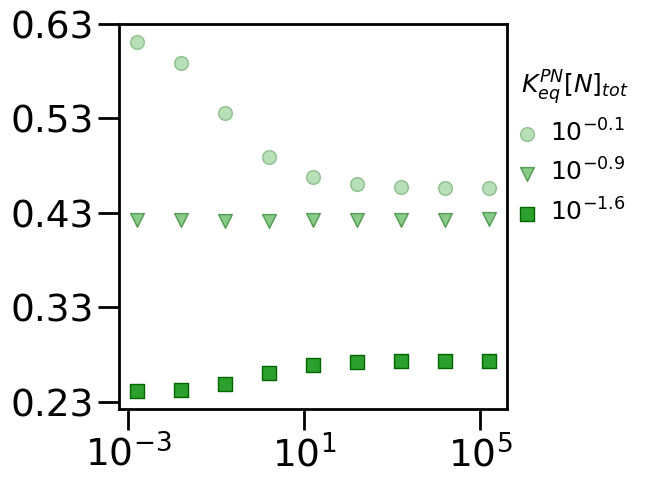

In [216]:
# >>>>>>>>>>>>>>>>>>>>>>>> Initialize Plotting >>>>>>>>>>>>>>>>>>>>>>>>
ax, colors, lineStyles, legend, labelfont, tickfont, C0 = plotHeader(
    scale=1.0, fixSize=True, sizeX=5, sizeY=5,
    lgdLoc=[1.01,0.45], lgdFontSize=18, lgdHandleL=0.3, 
    lgdTitle='$K_{eq}^{PN}[N]_{tot}$', lgdTtlFontSize=18,
    labelFontSize=20, tickFontSize=27, 
    tickL=15, tickW=2, spineLineW=2
)
gam_color = 'tab:green'
alphas = [3/9, 5/9, 1]
# alphas = [1/9, 3/9, 5/9, 7/9, 1]
markers = ['o','v','s', 'X', 'p']
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
gamList = np.unique(parm_file['gamma'])
kpnList = np.unique(parm_file['KPN'])
CN0 = np.unique(parm_file['CN0'])
for i, kpn in enumerate(kpnList[::-1]):
    selected = ((parm_file['KPN']==kpn))
    selected_num = ((parm_num['KPN']==kpn))
#     ax.plot(
#         (parm_file['KPP']*parm_file['CP0'])[selected],
#         (occs / (parm_file['CP0']/parm_file['CS0']))[selected], 
#         color = gam_color, alpha=alphas[i], 
#         lw=2, zorder=5,
#     )
    ax.scatter(
        (parm_num['KPP']*parm_num['CP0'])[selected_num],
        (sOcc_num_rev / (parm_num['CP0']/parm_num['CS0']))[selected_num],
        marker=markers[i],  zorder=4, s=100,
        color = gam_color, edgecolor='darkgreen', alpha=alphas[i], 
        label='$10^{%.1f}$'%(np.log10(CN0*kpn)),
    )
            
ax.semilogx()
plt.legend(**legend)
plt.xticks([1e-3, 1e1, 1e5], ['$10^{-3}$', '$10^{1}$', '$10^{5}$'], **tickfont)
plt.yticks([0.23, 0.33, 0.43, 0.53, 0.63],**tickfont)
# plt.yticks([0.13, 0.26, 0.39, 0.52, 0.65],**tickfont)
plt.savefig('resT_vs_chiN_gamma_DIMER.png', transparent=True)